In [1]:
# Import packages
%load_ext autoreload
import sys
sys.path.append('../')

import matplotlib
matplotlib.rc_file('../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

import numpy as np
from tqdm import tqdm_notebook as tqdm
import pickle

import darkhistory.physics as phys
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
from H2 import *
from plotting_utils import plot_distortion

data_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/DarkHistory/H2_cooling/data/'
output_dir = '/Users/viviesque/Dropbox (MIT)/DM and first BHs/Output/'
fig_dir = '/Users/viviesque/Dropbox (MIT)/DM and first BHs/Figures/'

# Load data for fiducial models

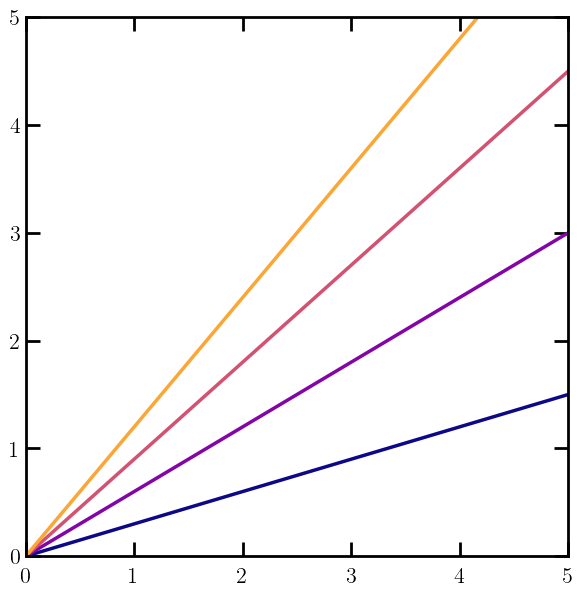

In [2]:
# Uniform color scheme for plots
cfast = cm.plasma(0.6)
cslow = cm.plasma(0)

cmap = cm.plasma(np.linspace(0.,0.8,4))

plt.figure(figsize=(7,7,))
for ii, col in enumerate(cmap):
    plt.plot(range(10), (ii+1)*0.3*np.arange(10), color=col)
plt.axis([0,5,0,5])
plt.show()

In [3]:
%autoreload
DH_data = {}
specs_list = {}
data_list = {}

# LCDM data
DH_data['LCDM'] = pickle.load(open(data_dir+'phot_decay_log10mDM_8.0000_log10param_40.0000_no_DM_nmax_200_reprocessed_ind_0.p', 'rb'))
specs_list['LCDM'] = repack_distortions(DH_data['LCDM'])
data_list['LCDM'] = None

# Model with smaller lifetime/more energy injection. Collapse dominated by heating.
DH_data['fast'] = pickle.load(open(data_dir+"elec_decay_log10mDM_8.2667_log10param_25.5556_nmax100_no_reion_ind_34.p", 'rb'))
specs_list['fast'] = repack_distortions(DH_data['fast'])
data_list['fast'] = repack_DH_data(DH_data['fast'])

# Model with larger lifetime/less energy injection. Collapse dominated by ionization.
DH_data['slow'] = pickle.load(open(data_dir+"elec_decay_log10mDM_8.2667_log10param_26.4444_nmax100_no_reion_ind_35.p", 'rb'))
specs_list['slow'] = repack_distortions(DH_data['slow'])
data_list['slow'] = repack_DH_data(DH_data['slow'])

  0%|          | 0/414 [00:00<?, ?it/s]

/Users/viviesque/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/DarkHistory/DarkHistory/H2_cooling/../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

In [4]:
# Redshift list, since it's usually the same for all data files
rs_list = DH_data['LCDM']['data'][-1]['rs']
dlnz = np.log(rs_list[0])-np.log(rs_list[1])

# Timescales for evolution

Using rs_vir = 20,
M_halo = 1434789.7020351316 solar masses,
T_vir = 1600 K.
Required step size is less than spacing between numbers.
using collapse factor 0.75
Halo collapses? True


/Users/viviesque/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/DarkHistory/DarkHistory/H2_cooling/H2.py:475: RuntimeWarning: divide by zero encountered in divide
  return - T / dTm_dt_DM(rs, xe, n, DM_args, DM_switch, f_suppress)


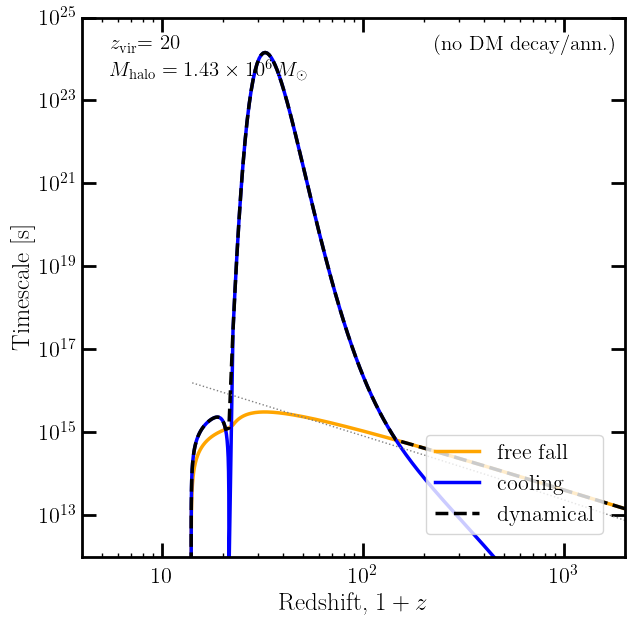

In [5]:
%autoreload
start_rs = 2000.
end_rs = 4.

rs_vir = 20
Tvir = 1.6e3 * phys.kB
M_halo = M_given_T(rs_vir, Tvir)#phys.TCMB(rs_vir))
init_H2 = [1e-10]

print(f"Using rs_vir = {rs_vir},") 
print(f"M_halo = {M_halo} solar masses,")
print(f"T_vir = {T_vir(rs_vir, M_halo)/phys.kB:.0f} K.")

halo_data = {}
rs_vir_actual = {}

for key in ['LCDM']: #, 'fast', 'slow']: #DH_data.keys():
    if key=='LCDM':
        DM_switch = False
    else:
        DM_switch = True

    halo_data[key], rs_vir_actual[key] = halo_integrate(
        rs_vir, M_halo, init_H2, start_rs=start_rs, end_rs=end_rs,
        dists=specs_list[key], DM_switch=DM_switch, DM_args=data_list[key]
    )    
    if key != 'LCDM':
        halo_data[key+' LW'], rs_vir_actual[key+' LW'] = halo_integrate(
            rs_vir, M_halo, init_H2, start_rs=start_rs, end_rs=end_rs,
            dists=specs_list[key], DM_switch=DM_switch, DM_args=data_list[key],
            LW=True
        )
        # halo_data[key+' fhalo'], rs_vir_actual[key+' fhalo'] = halo_integrate(
        #     rs_vir, M_halo, init_H2, start_rs=start_rs, end_rs=end_rs,
        #     dists=specs_list[key], DM_switch=DM_switch, DM_args=data_list[key], 
        #     f_suppress=True
        # )
    print("Halo collapses?", collapse_criterion(halo_data[key]['t'], halo_data[key]['y'][2], rs_vir_actual[key]))

    # Get rid of discontinuity
    discont_mask = np.roll(halo_data[key]['t'] != rs_vir_actual[key], -1)
    # discont_mask_fs = np.roll(halo_data[key+' fhalo']['t'] != rs_vir_actual[key+' fhalo'], -1)

    rs = halo_data[key]['t'][discont_mask]
    xe = halo_data[key]['y'][0][discont_mask]
    xH2 = halo_data[key]['y'][1][discont_mask]
    T = halo_data[key]['y'][2][discont_mask]
    n = halo_data[key]['y'][3][discont_mask]
    rho = n * (phys.rho_DM + phys.rho_baryon) / phys.nH
    
    # Calculate relevant timescales:
    test_t_ff = t_ff(rho)
    test_t_cool = t_cool(xe, xH2, T, n, rs)
    test_t_heat = t_heat(rs, xe, T, n, DM_args=data_list[key], DM_switch=DM_switch)

    test_t_dyn = t_dyn(
        rho, xe, xH2, T, n, rs,
        DM_switch=DM_switch, DM_args=data_list[key]
    )

    plt.figure(figsize=(7,7))
    ax = plt.gca()
    plt.loglog()

    # Plot timescales
    plt.plot(rs, test_t_ff, color='orange', label='free fall')
    plt.plot(rs, test_t_cool, color='b', label='cooling')
    if key != 'LCDM':
        plt.plot(rs, test_t_heat, color='r', label='exotic heating')
    plt.plot(rs, test_t_dyn, color='k', linestyle='--', label='dynamical')
    plt.plot(rs, 1/phys.hubble(rs), color='gray', linestyle=':', linewidth=1)

    # Plot negative values
    plt.plot(rs, -test_t_ff, color='orange', linestyle=':')
    plt.plot(rs, -test_t_cool, color='b', linestyle=':')
    if key != 'LCDM':
        plt.plot(rs, -test_t_heat, color='r', linestyle=':')
    plt.plot(rs, -test_t_dyn, color='k', linestyle=':')

    plt.axis([4, 2000, 1e12, 1e25])
    plt.legend(loc='lower right')
    
    plt.xlabel(r'Redshift, $1+z$')
    plt.ylabel(r'Timescale [s]')
    plt.text(0.05, 0.94, r"$z_\mathrm{vir}$"+f"= {rs_vir:.0f}", fontsize=15, transform = ax.transAxes)
    plt.text(0.05, 0.89, r"$M_\mathrm{halo} = 1.43 \times 10^6 \, M_\odot$", fontsize=15, transform = ax.transAxes)
    if key != 'LCDM':
        if key == 'fast':
            plt.text(0.65, 0.94, r"Model $\bullet$:", fontsize=15, transform = ax.transAxes)
        else:
            plt.text(0.65, 0.94, r"Model $\star$:", fontsize=15, transform = ax.transAxes)
        plt.text(0.65, 0.89, fr"$\chi \rightarrow e^+ e^-$,", fontsize=15, transform = ax.transAxes)
        plt.text(0.65, 0.84, fr"$m_\chi$ = {DH_data[key]['DM_params']['mDM']/1e6:.2f} MeV", fontsize=15, transform = ax.transAxes)
        plt.text(0.65, 0.79, r"$\log_{10} \tau$ [s] = "+fr"{np.log10(DH_data[key]['DM_params']['inj_param']):.1f}", fontsize=15, transform = ax.transAxes)
    else:
        plt.text(0.65, 0.94, fr"(no DM decay/ann.)", fontsize=15, transform = ax.transAxes)

    plt.savefig(fig_dir+f'timescales_zvir{rs_vir:.0f}_M{M_halo:.2E}_{key}.pdf')
    plt.show()

# Examples of halo evolution, with and without energy injection

Using rs_vir = 20,
M_halo = 1434789.7020351316 solar masses,
T_vir = 1600 K.
Required step size is less than spacing between numbers.


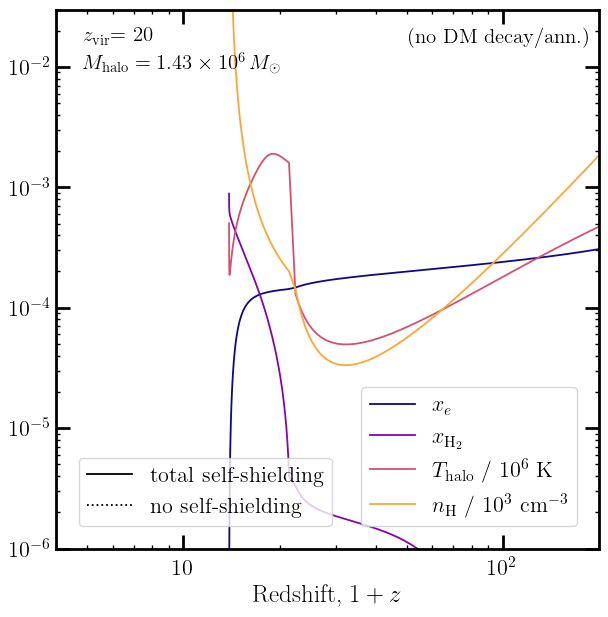

In [6]:
%autoreload
start_rs = 2000.
end_rs = 4.

rs_vir = 20
Tvir = 1.6e3 * phys.kB
M_halo = M_given_T(rs_vir, Tvir)#phys.TCMB(rs_vir))
init_log_H2 = [np.log(1e-10)]

print(f"Using rs_vir = {rs_vir},") 
print(f"M_halo = {M_halo} solar masses,")
print(f"T_vir = {T_vir(rs_vir, M_halo)/phys.kB:.0f} K.")

halo_data = {}
rs_vir_actual = {}

for key in ['LCDM']: #, 'fast', 'slow']: #DH_data.keys():
    if key=='LCDM':
        DM_switch = False
    else:
        DM_switch = True

    halo_data[key], rs_vir_actual[key] = halo_integrate(
        rs_vir, M_halo, init_log_H2, start_rs=start_rs, end_rs=end_rs,
        dists=specs_list[key], DM_switch=DM_switch, DM_args=data_list[key]
    )    
    if key != 'LCDM':
        halo_data[key+' LW'], rs_vir_actual[key+' LW'] = halo_integrate(
            rs_vir, M_halo, init_log_H2, start_rs=start_rs, end_rs=end_rs,
            dists=specs_list[key], DM_switch=DM_switch, DM_args=data_list[key],
            LW=True
        )
        # halo_data[key+' fhalo'], rs_vir_actual[key+' fhalo'] = halo_integrate(
        #     rs_vir, M_halo, init_log_H2, start_rs=start_rs, end_rs=end_rs,
        #     dists=specs_list[key], DM_switch=DM_switch, DM_args=data_list[key], 
        #     f_suppress=True
        # )
    # print("Halo collapses?", collapse_criterion(halo_data[key]['t'], halo_data[key]['y'][2], rs_vir_actual[key]))

    # Get rid of discontinuity
    discont_mask = np.roll(halo_data[key]['t'] != rs_vir_actual[key], -1)
    # discont_mask_fs = np.roll(halo_data[key+' fhalo']['t'] != rs_vir_actual[key+' fhalo'], -1)

    plt.figure(figsize=(7,7))
    ax = plt.gca()
    plt.loglog()

    plt.plot(halo_data[key]['t'][discont_mask], halo_data[key]['y'][0][discont_mask], 
             linewidth=1.3,color=cmap[0], label=r'$x_e$')
    plt.plot(halo_data[key]['t'][discont_mask], halo_data[key]['y'][1][discont_mask], 
             linewidth=1.3,color=cmap[1], label=r'$x_{\mathrm{H}_2}$')
    plt.plot(halo_data[key]['t'][discont_mask], halo_data[key]['y'][2][discont_mask] / phys.kB / 1e6, 
             linewidth=1.3,color=cmap[2], label=r'$T_\mathrm{halo}$ / 10$^6$ K')
    plt.plot(halo_data[key]['t'][discont_mask], halo_data[key]['y'][3][discont_mask] / 1e3, 
             linewidth=1.3,color=cmap[3], label=r'$n_\mathrm{H}$ / 10$^3$ cm$^{-3}$')
    
    if key != 'LCDM':
        discont_mask_LW = np.roll(halo_data[key+' LW']['t'] != rs_vir_actual[key+' LW'], -1)
        plt.plot(halo_data[key+' LW']['t'][discont_mask_LW], halo_data[key+' LW']['y'][0][discont_mask_LW], 
                linewidth=1.3,color=cmap[0], linestyle=':')
        plt.plot(halo_data[key+' LW']['t'][discont_mask_LW], halo_data[key+' LW']['y'][1][discont_mask_LW], 
                linewidth=1.3,color=cmap[1], linestyle=':')
        plt.plot(halo_data[key+' LW']['t'][discont_mask_LW], halo_data[key+' LW']['y'][2][discont_mask_LW] / phys.kB / 1e6, 
                linewidth=1.3,color=cmap[2], linestyle=':')
        plt.plot(halo_data[key+' LW']['t'][discont_mask_LW], halo_data[key+' LW']['y'][3][discont_mask_LW] / 1e3, 
                linewidth=1.3,color=cmap[3], linestyle=':')

    # plt.plot(rs_list, phys.Tm_std(rs_list) / phys.kB / 1e6, label=r'$T_\mathrm{IGM}$ / 10$^6$ K',
    #         linewidth=1, linestyle='--', color='r')
    # plt.plot(rs_list, phys.nH * rs_list**3 / 1e3, label=r'IGM density / 10$^3$ cm$^{-3}$',
    #         linewidth=1, linestyle='--', color='grey')
    plt.axis([4, 200, 1e-6, 3e-2])


    # Make a second legend if including LW
    nLW, = plt.plot([0,0], color='k', linewidth=1.3)
    wLW, = plt.plot([0,0], color='k', linewidth=1.3, linestyle=':')
    lLW = plt.legend([nLW, wLW], ["total self-shielding", "no self-shielding"], loc='lower left')

    plt.legend(loc='lower right')
    ax.add_artist(lLW)
    plt.xlabel(r'Redshift, $1+z$')
    plt.text(0.05, 0.94, r"$z_\mathrm{vir}$"+f"= {rs_vir:.0f}", fontsize=15, transform = ax.transAxes)
    plt.text(0.05, 0.89, r"$M_\mathrm{halo} = 1.43 \times 10^6 \, M_\odot$", fontsize=15, transform = ax.transAxes)
    if key != 'LCDM':
        if key == 'fast':
            plt.text(0.65, 0.94, r"Model $\bullet$:", fontsize=15, transform = ax.transAxes)
        else:
            plt.text(0.65, 0.94, r"Model $\star$:", fontsize=15, transform = ax.transAxes)
        plt.text(0.65, 0.89, fr"$\chi \rightarrow e^+ e^-$,", fontsize=15, transform = ax.transAxes)
        plt.text(0.65, 0.84, fr"$m_\chi$ = {DH_data[key]['DM_params']['mDM']/1e6:.2f} MeV", fontsize=15, transform = ax.transAxes)
        plt.text(0.65, 0.79, r"$\log_{10} \tau$ [s] = "+fr"{np.log10(DH_data[key]['DM_params']['inj_param']):.1f}", fontsize=15, transform = ax.transAxes)
    else:
        plt.text(0.65, 0.94, fr"(no DM decay/ann.)", fontsize=15, transform = ax.transAxes)

    # plt.savefig(fig_dir+f'LW_halo_evol_zvir{rs_vir:.0f}_M{M_halo:.2E}_{key}.pdf')
    plt.show()

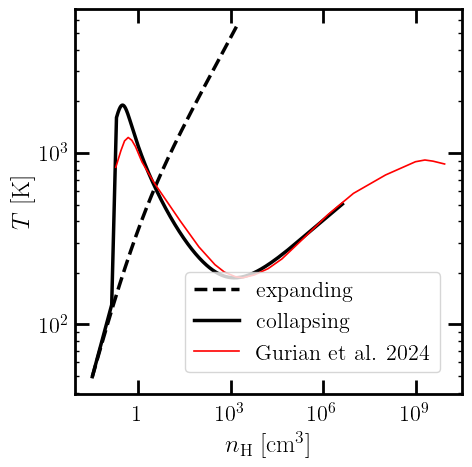

In [8]:
T = halo_data['LCDM']['y'][2][discont_mask] / phys.kB
nH = halo_data['LCDM']['y'][3][discont_mask]
ind_min = np.argmin(nH)

Gurian_fig1 = np.array([
    [0.19200176793036725, 824.9924976324792],
    [0.2809096188343848, 1031.5242572239092],
    [0.3686467888838656, 1175.8822432395825],
    [0.48378711814246567, 1231.5694901712286],
    [0.6348895005683186, 1185.1265106842777],
    [0.8331860498468026, 1088.9391579542976],
    [1.3590045495438539, 884.613109855885],
    [3.2431065262241185, 675.7510886790784],
    [22.954978859321542, 403.5613109582194],
    [94.3419590671777, 283.27614825570913],
    [311.959207045009, 223.17994048785377],
    [632.4290409432389, 201.95295663953402],
    [1429.3656429973596, 189.92361232235444],
    [2461.676777274177, 187.04512693392786],
    [5874.5057362110165, 194.42810576928412],
    [16502.05167199444, 211.66814387464603],
    [46355.8504516527, 241.33418690781673],
    [170889.3541498248, 301.8173297897219],
    [1423826.2594496352, 437.0179214170039],
    [9544735.816778373, 581.3564084849605],
    [104363767.12515171, 744.24175613256],
    [969413972.0638154, 888.9316042783801],
    [1965274737.1576757, 909.861127798159],
    [3573713479.0047784, 896.0828944410088],
    [8528252175.83392, 862.4144367917993]
])

plt.figure(figsize=(5,5))
plt.loglog()
plt.plot(nH[:ind_min], T[:ind_min], color='k', linestyle='--', label="expanding")
plt.plot(nH[ind_min:], T[ind_min:], color='k', label='collapsing')
plt.plot(Gurian_fig1[:,0] ,Gurian_fig1[:,1] , color='r', linewidth=1.2, label='Gurian et al. 2024')
plt.xlabel(r"$n_\mathrm{H}$ [cm$^3$]")
plt.ylabel(r"$T$ [K]")
plt.legend()
plt.show()